<a href="https://colab.research.google.com/github/isralennon/MSAAI530/blob/YAS/USD%2C_IoT%2C_Final_Project%2C_Forecast_future_accelerometer_values%2C_i0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Load data & imports
!wget https://archive.ics.uci.edu/static/public/780/har70.zip
!unzip -q har70.zip

import os
import glob
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

--2025-02-15 22:42:27--  https://archive.ics.uci.edu/static/public/780/har70.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘har70.zip’

har70.zip               [           <=>      ]  42.22M  15.0MB/s    in 2.8s    

2025-02-15 22:42:30 (15.0 MB/s) - ‘har70.zip’ saved [44267192]



Preprocessing

In [ ]:
# Set directory
DATA_DIR = "har70plus"

# Get list of all CSVs
csv_files = glob.glob(os.path.join(DATA_DIR, "*.csv"))
print(f"Found {len(csv_files)} CSV files.")

# Just going with a single chennel for this iteration (e.g., 'back_x')
sensor_channel = 'back_x'

# Define split ratios (chronological split per subject)
train_ratio = 0.70
val_ratio = 0.15  # test will be the remainder

# Lists to hold raw sensor data splits
train_series_list = []
val_series_list = []
test_series_list = []

# Process each CSV file/subject)
for file in csv_files:
    df = pd.read_csv(file)
    # Convert timestamp column to datetime and sort by time
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.sort_values('timestamp')

    # Extract raw sensor values for the chosen channel
    sensor_values = df[sensor_channel].values
    N = len(sensor_values)

    # Ensures series is long enough for splitting & windowing
    if N < 60:  # 60 is a loose minimum (could be input_window + forecast_window)
        continue

    # Compute split indices (chronologically)
    train_end = int(N * train_ratio)
    val_end = train_end + int(N * val_ratio)

    train_series_list.append(sensor_values[:train_end])
    val_series_list.append(sensor_values[train_end:val_end])
    test_series_list.append(sensor_values[val_end:])

# Combine all training data to fit a global scaler (avoids data leakage)
all_train_values = np.concatenate(train_series_list).reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(all_train_values)

# Define window & forecast sizes
input_window = 50    # past 50 time steps as input
forecast_window = 10 # next 10 time steps as target

def create_windows(series_list, input_window, forecast_window, scaler):
    """
    For each series in the list, apply the scaler and then create sliding windows.
    Returns arrays for inputs (X) and targets (y).
    """
    X_windows, y_windows = [], []
    for series in series_list:
        # Scale series using pre-fitted scaler
        series_scaled = scaler.transform(series.reshape(-1, 1)).flatten()
        # Create sliding windows
        for i in range(len(series_scaled) - input_window - forecast_window + 1):
            x_window = series_scaled[i : i + input_window]
            y_window = series_scaled[i + input_window : i + input_window + forecast_window]
            X_windows.append(x_window)
            y_windows.append(y_window)
    return np.array(X_windows), np.array(y_windows)

# Create windows for each split
X_train, y_train = create_windows(train_series_list, input_window, forecast_window, scaler)
X_val, y_val     = create_windows(val_series_list, input_window, forecast_window, scaler)
X_test, y_test   = create_windows(test_series_list, input_window, forecast_window, scaler)

# Reshape arrays to add feature dimension (univariate time series)
X_train = X_train.reshape(-1, input_window, 1)
y_train = y_train.reshape(-1, forecast_window, 1)
X_val   = X_val.reshape(-1, input_window, 1)
y_val   = y_val.reshape(-1, forecast_window, 1)
X_test  = X_test.reshape(-1, input_window, 1)
y_test  = y_test.reshape(-1, forecast_window, 1)

print("Training data shape (X):", X_train.shape)
print("Validation data shape (X):", X_val.shape)
print("Test data shape (X):", X_test.shape)


Found 18 CSV files.
Training data shape (X): (1580648, 50, 1)
Validation data shape (X): (337869, 50, 1)
Test data shape (X): (337894, 50, 1)


Model Building

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Reshape

# Define forecast window (must match windowing step in preprocessing)
forecast_window = 10

# Build model
model = Sequential([
    # First LSTM layer: returns a sequence to feed into the next LSTM layer
    LSTM(50, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    # Second LSTM layer: returns only the final hidden state
    LSTM(30, activation='tanh'),
    # Dense layer to produce forecast_window outputs
    Dense(forecast_window),
    # Reshape to match our target shape (forecast_window, 1)
    Reshape((forecast_window, 1))
])

# Compile model using MSE loss for regression
model.compile(optimizer='adam', loss='mse')

# Print model summary
model.summary()

# Train model
history = model.fit(X_train, y_train,
                    epochs=20,
                    batch_size=32,
                    validation_data=(X_val, y_val))

# Evaluate model
test_loss = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 50, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 30)                  │           9,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 10)                  │             310 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 10, 1)               │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,430 (79.80 KB)

 Trainable params: 20,430 (79.80 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
49396/49396 ━━━━━━━━━━━━━━━━━━━━ 350s 7ms/step - loss: 0.0015 - val_loss: 5.9155e-04
Epoch 2/20
49396/49396 ━━━━━━━━━━━━━━━━━━━━ 343s 7ms/step - loss: 2.2097e-04 - val_loss: 5.2199e-04
Epoch 3/20
49396/49396 ━━━━━━━━━━━━━━━━━━━━ 342s 7ms/step - loss: 1.9572e-04 - val_loss: 4.8300e-04
Epoch 4/20
49396/49396 ━━━━━━━━━━━━━━━━━━━━ 345s 7ms/step - loss: 1.8074e-04 - val_loss: 4.7137e-04
Epoch 5/20
49396/49396 ━━━━━━━━━━━━━━━━━━━━ 343s 7ms/step - loss: 1.7323e-04 - val_loss: 4.5136e-04
Epoch 6/20
49396/49396 ━━━━━━━━━━━━━━━━━━━━ 342s 7ms/step - loss: 1.6717e-04 - val_loss: 4.5740e-04
Epoch 7/20
49396/49396 ━━━━━━━━━━━━━━━━━━━━ 344s 7ms/step - loss: 1.6218e-04 - val_loss: 4.4074e-04
Epoch 8/20
49396/49396 ━━━━━━━━━━━━━━━━━━━━ 345s 7ms/step - loss: 1.6024e-04 - val_loss: 4.4133e-04
Epoch 9/20
49396/49396 ━━━━━━━━━━━━━━━━━━━━ 344s 7ms/step - loss: 1.5641e-04 - val_loss: 4.3706e-04
Epoch 10/20
49396/49396 ━━━━━━━━━━━━━━━━━━━━ 344s 7ms/step - loss: 1.5358e-04 - val_loss: 4.2815e-04
Epo

10560/10560 ━━━━━━━━━━━━━━━━━━━━ 25s 2ms/step
Mean Squared Error on Test Set: 0.0002914303203058621


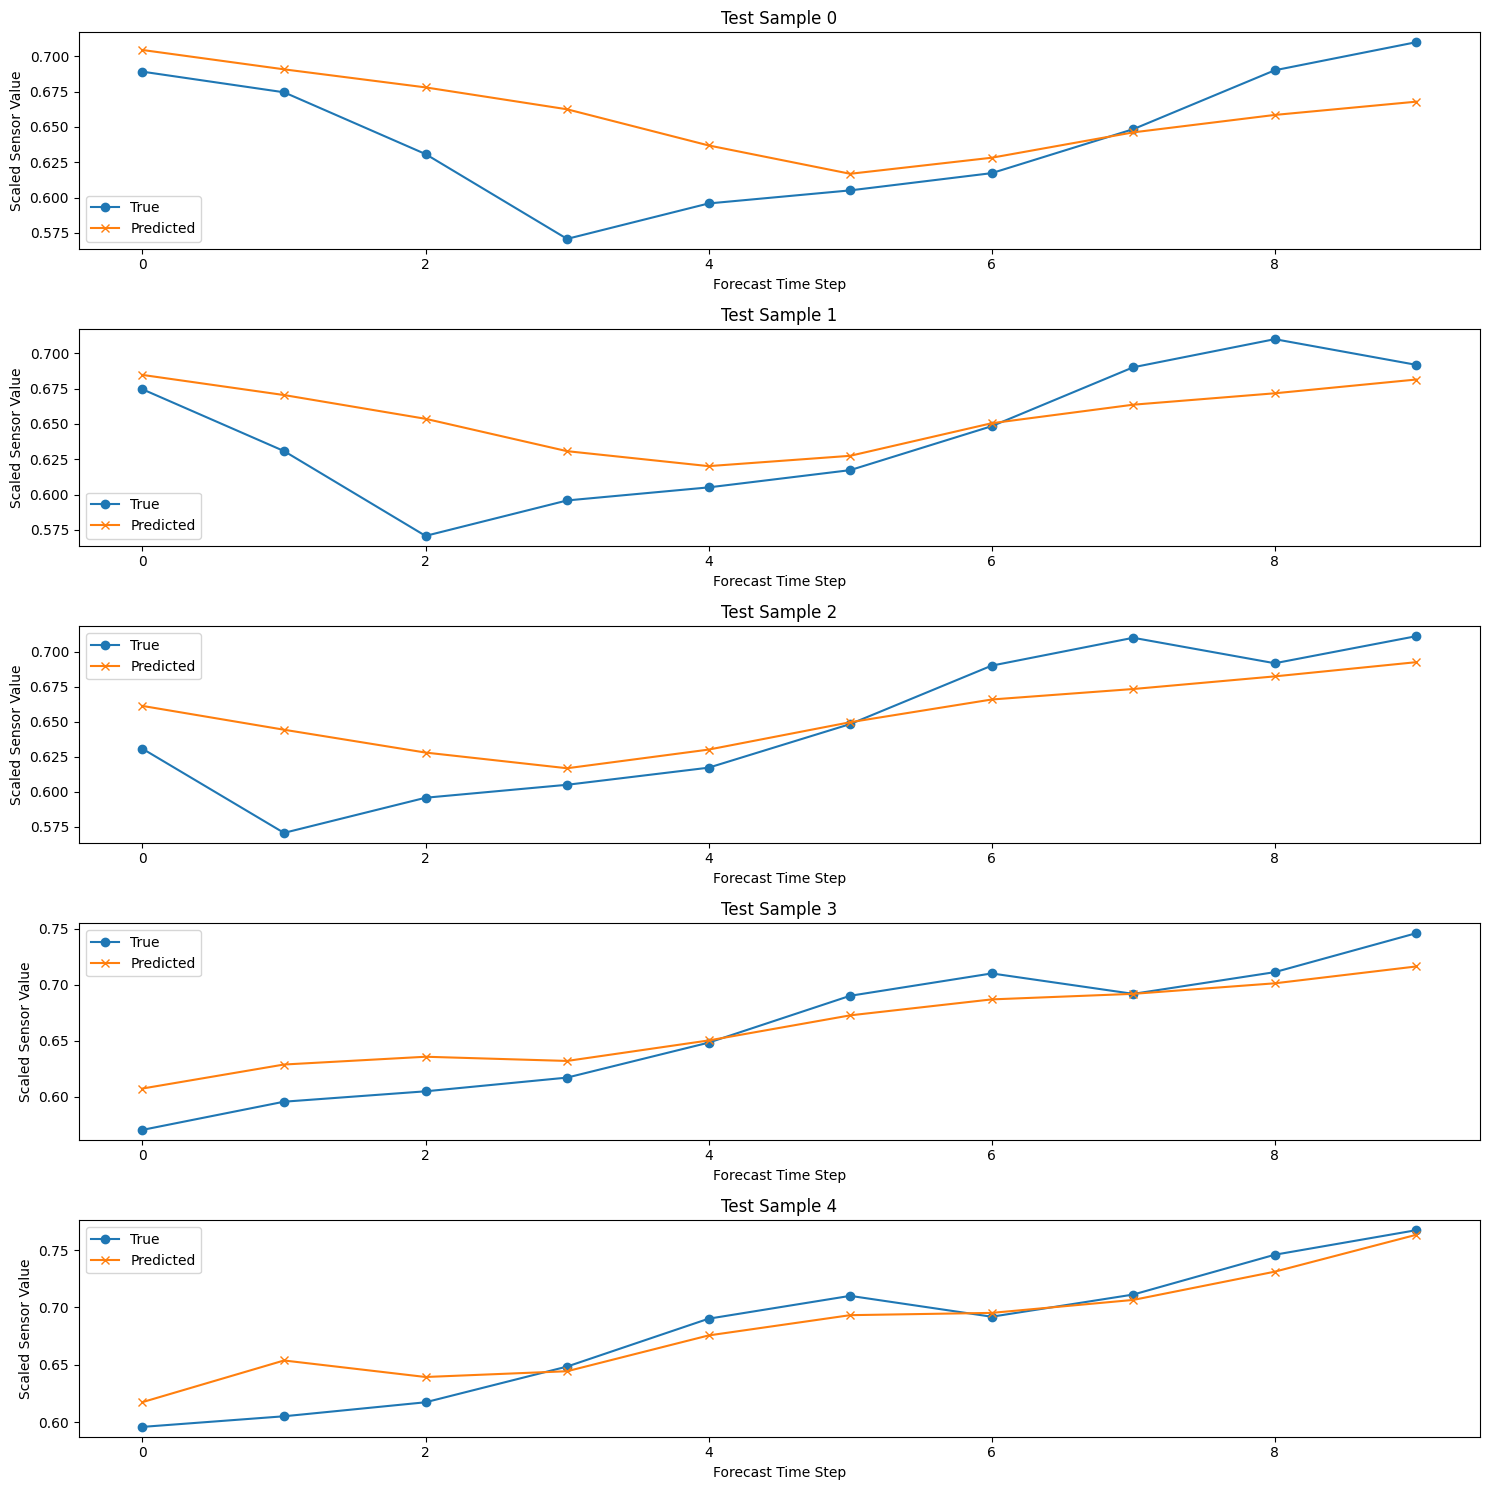

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Generate predictions on test set
predictions = model.predict(X_test)

# Get MSE for test set
test_mse = mean_squared_error(y_test.flatten(), predictions.flatten())
print("Mean Squared Error on Test Set:", test_mse)

# Plot predictions vs. true values for a few test samples
num_samples_to_plot = 5
plt.figure(figsize=(15, num_samples_to_plot * 3))

for i in range(num_samples_to_plot):
    plt.subplot(num_samples_to_plot, 1, i+1)
    # Plot true target sequence
    plt.plot(y_test[i].flatten(), label='True', marker='o')
    # Plot predicted sequence
    plt.plot(predictions[i].flatten(), label='Predicted', marker='x')
    plt.title(f"Test Sample {i}")
    plt.xlabel("Forecast Time Step")
    plt.ylabel("Scaled Sensor Value")
    plt.legend()

plt.tight_layout()
plt.show()


Model saved as forecasting_model.keras
Training history saved to training_history.json
Evaluation metrics saved to evaluation_metrics.txt
10560/10560 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step
Results saved to forecasting_results.csv


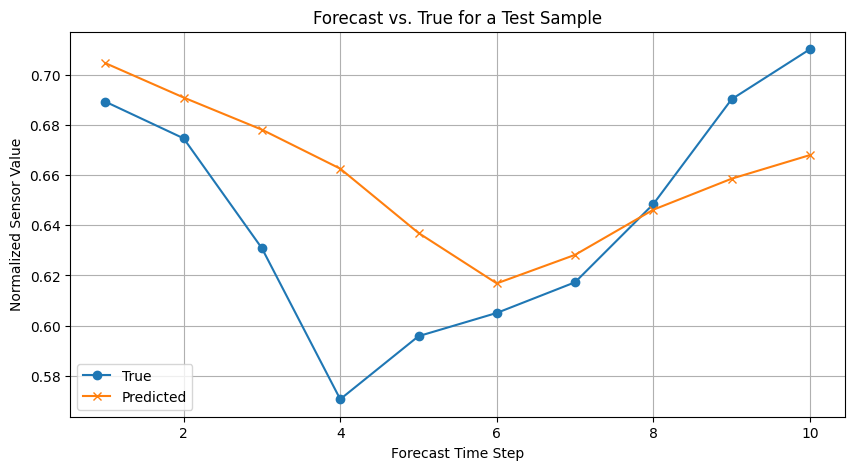

Forecast plot saved as forecast_vs_true.png


In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

# Save model
model.save('forecasting_model.keras')
print("Model saved as forecasting_model.keras")

# Save training history
with open('training_history.json', 'w') as f:
    json.dump(history.history, f)
print("Training history saved to training_history.json")

# Evaluate & Save Evaluation Metrics
test_loss = model.evaluate(X_test, y_test, verbose=0)
with open('evaluation_metrics.txt', 'w') as f:
    f.write(f"Test Loss: {test_loss}\n")
print("Evaluation metrics saved to evaluation_metrics.txt")

# Save Forecasting Results
predictions = model.predict(X_test)

# Reshape predictions & true values for saving
# Each row corresponds to one test sample with forecast_window values
pred_df = pd.DataFrame(predictions.reshape(predictions.shape[0], predictions.shape[1]),
                       columns=[f'pred_t{i}' for i in range(1, predictions.shape[1]+1)])
true_df = pd.DataFrame(y_test.reshape(y_test.shape[0], y_test.shape[1]),
                       columns=[f'true_t{i}' for i in range(1, y_test.shape[1]+1)])

# Combine predictions & ground truth side-by-side
results_df = pd.concat([pred_df, true_df], axis=1)
results_df.to_csv('forecasting_results.csv', index=False)
print("Results saved to forecasting_results.csv")

# Plot the forecast versus true values for a sample test window.
# First test sample.
sample_idx = 0
plt.figure(figsize=(10, 5))
plt.plot(range(1, forecast_window+1), y_test[sample_idx].flatten(), label='True', marker='o')
plt.plot(range(1, forecast_window+1), predictions[sample_idx].flatten(), label='Predicted', marker='x')
plt.xlabel('Forecast Time Step')
plt.ylabel('Normalized Sensor Value')
plt.title('Forecast vs. True for a Test Sample')
plt.legend()
plt.grid(True)
plt.savefig('forecast_vs_true.png')
plt.show()
print("Forecast plot saved as forecast_vs_true.png")
